<a href="https://colab.research.google.com/github/Ahmed-L/CSE465-/blob/main/RAVDESS_SER.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Unzip Dataset (RAVDESS)

# Download And Extract

In [1]:

!gdown --id 1UBZLKSiAJyKoIy_cvIH94ad0EhJLO1vY # Ravdess
!gdown --id 1a3R72CZ7IYNa68dQ9UDBQGNr8CWGnHrl # Ravdess csv
import zipfile
dataset_directory = '/content/Audio_Speech_Actors_01-24.zip' # RAVDESS
zip_ref = zipfile.ZipFile(dataset_directory, 'r')
zip_ref.extractall('Unzipped_Data')

import pandas as pd
from sklearn.model_selection import train_test_split
csv =  pd.read_csv('/content/ravdess_data.csv')
for index, row in csv.iterrows():
  if (row['Emotion_ID']==0):
    csv.drop(index, axis=0, inplace = True)

csv['Emotion_ID'].replace({1:0, 2:1, 3:2, 4:3, 5:4, 6:5, 7:6}, inplace=True)
y = pd.DataFrame(csv[['Emotion_ID']])

train_csv, test_csv = train_test_split(csv, random_state = 0, stratify=y, test_size = 0.2097, shuffle = True)


y = pd.DataFrame(train_csv[['Emotion_ID']])
train_csv, val_csv = train_test_split(train_csv, random_state = 0, stratify=y, train_size = 0.886, shuffle = True)
val_csv.to_csv(r'val_csv.csv', index=False)
train_csv.to_csv(r'train_csv.csv', index=False)
test_csv.to_csv(r'test_csv.csv', index=False)
print(len(train_csv))
print(len(test_csv))
print(len(val_csv))

Downloading...
From: https://drive.google.com/uc?id=1UBZLKSiAJyKoIy_cvIH94ad0EhJLO1vY
To: /content/Audio_Speech_Actors_01-24.zip
100% 208M/208M [00:02<00:00, 89.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=1a3R72CZ7IYNa68dQ9UDBQGNr8CWGnHrl
To: /content/ravdess_data.csv
100% 94.0k/94.0k [00:00<00:00, 22.5MB/s]
940
282
122


# Custom Dataset Class

Create custom Dataset

In [4]:
import os
import torch
from torch.utils.data import Dataset
import pandas as pd
import torchaudio
from torch.utils.data import DataLoader
import torch.optim.lr_scheduler as lr_scheduler
from torch.nn.functional import normalize


class CustomDataset(Dataset):
    def __init__(self, annotations_file, audio_dir, transformation, target_sample_rate, num_samples, device):
        self.annotations = pd.read_csv(annotations_file)
        self.audio_dir = audio_dir
        self.device = device
        self.transformation = transformation.to(self.device)
        self.target_sample_rate = target_sample_rate
        self.num_samples = num_samples

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        audio_sample_path = self._get_audio_sample_path(index)
        #print(audio_sample_path)
        label = self._get_audio_sample_label(index)
        #print(label)
        #signal, sr = torchaudio.load(audio_sample_path,frame_offset=int(self.num_samples*.3),num_frames = self.target_sample_rate)
        signal, sr = torchaudio.load(audio_sample_path)
        signal = signal.to(self.device)
        signal = self._resample_if_necessary(signal, sr)
        signal = self._mix_down_if_necessary(signal)
        signal = self._cut_if_necessary(signal)
        signal = self._right_pad_if_necessary(signal)
        signal = self.transformation(signal)
        # produce delta and delta-delta and add to mfcc
        delta = torchaudio.functional.compute_deltas(signal)
        delta2 = torchaudio.functional.compute_deltas(delta)
        signal = torch.cat((signal, delta, delta2), 1) # concatenating deltas
        
        #signal = signal + delta + delta2
        means = signal.mean(dim=1, keepdim=True)
        stds = signal.std(dim=1, keepdim=True)
        signal = (signal - means) / stds #NORMALIZED

        return signal, label

    def _cut_if_necessary(self, signal):
        if signal.shape[1] > self.num_samples:
            # print(signal.shape[1]) # print sample size
            signal = signal[:, :self.num_samples]
        return signal

    def _right_pad_if_necessary(self, signal):
        length_signal = signal.shape[1]
        if length_signal < self.num_samples:
            num_missing_samples = self.num_samples - length_signal
            last_dim_padding = (0, num_missing_samples)
            signal = torch.nn.functional.pad(signal, last_dim_padding)
        return signal

    def _resample_if_necessary(self, signal, sr):
        if sr != self.target_sample_rate:
            resampler = torchaudio.transforms.Resample(sr, self.target_sample_rate)
            resampler = resampler.to(device)
            signal = resampler(signal)
        return signal

    def _mix_down_if_necessary(self, signal):
        if signal.shape[0] > 1:
            signal = torch.mean(signal, dim=0, keepdim=True)
        return signal

    # for any audio index this function returns the audio path
    def _get_audio_sample_path(self, index):
        path = os.path.join(self.audio_dir, self.annotations.iloc[index,0])
        return path
    
    # for specified audio index this will return the label from the data csv
    def _get_audio_sample_label(self, index):
        return self.annotations.iloc[index, 2]

Instantiate the dataset

In [5]:

TRAIN_CSV = '/content/train_csv.csv'
TEST_CSV = '/content/test_csv.csv'
VALID_CSV = '/content/val_csv.csv'

TRAIN_PATH = ''
TEST_PATH = ''
VALID_PATH = ''

SAMPLE_RATE = 48000
NUM_SAMPLES = SAMPLE_RATE*4

device = ''
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
print(f"Using device {device}")

#mfcc = torchaudio.transforms.MelSpectrogram(sample_rate=SAMPLE_RATE, n_mels = 70,n_fft = 600)
mfcc = torchaudio.transforms.MFCC(sample_rate=SAMPLE_RATE, n_mfcc=44, melkwargs={"n_fft": 1536, "hop_length": 512, "power": 2})
train_dataset = CustomDataset(TRAIN_CSV,
                        TRAIN_PATH,
                        mfcc,
                        SAMPLE_RATE,
                        NUM_SAMPLES,
                        device)
print(f"There are {len(train_dataset)} samples in the train.")

val_dataset = CustomDataset(VALID_CSV,
                        VALID_PATH,
                        mfcc,
                        SAMPLE_RATE,
                        NUM_SAMPLES,
                        device)

print(f"There are {len(val_dataset)} samples in the valid.")

test_dataset = CustomDataset(TEST_CSV,
                        TEST_PATH,
                        mfcc,
                        SAMPLE_RATE,
                        NUM_SAMPLES,
                        device)
print(f"There are {len(test_dataset)} samples in the test.")
signal, label = val_dataset[0]
print(signal.shape)

Using device cuda
There are 940 samples in the train.
There are 122 samples in the valid.
There are 282 samples in the test.
torch.Size([1, 132, 376])


# Model Loading and Functions

In [8]:
from torch import nn
from torchsummary import summary

from torchvision import models
model = models.resnet50(pretrained=True)

model = model.to(device)
model.conv1=nn.Conv2d(1, model.conv1.out_channels, 
                      kernel_size=model.conv1.kernel_size[0], 
                      stride=model.conv1.stride[0], 
                      padding=model.conv1.padding[0])
num_ftrs = model.fc.in_features
model.fc = nn.Sequential(*[nn.Dropout(p=0.25), nn.Linear(num_ftrs, 7)])

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [9]:
#!gdown --id 18hQTkVXPjlmxhFmpD2U9Qa_uhvYUY3M_
#model = torch.load('/content/Resnet_high_model.pth')
model = model.to(device)
#summary(model, signal.shape)

# Model Parameter Setting

In [10]:
from torch import nn
train_loss = []
val_loss = []
test_loss = []

train_acc = []
val_acc = []
test_acc = []

BATCH_SIZE = 64
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=10**-3, weight_decay = 10**-6)

#optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
#step_lr_scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='max',factor=0.1,patience=2, verbos=True)
#step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

def create_data_loader(train_data, batch_size):
    train_dataloader = DataLoader(train_data, batch_size=batch_size)
    return train_dataloader

train_dataloader = create_data_loader(train_dataset, BATCH_SIZE)
test_dataloader = create_data_loader(test_dataset, BATCH_SIZE)
val_dataloader = create_data_loader(val_dataset, BATCH_SIZE)

In [11]:
def train_loop(dataloader, model, criterion, optimizer):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    size = len(dataloader.dataset)  

    for batch, (X,y) in enumerate(dataloader):
        # Compute prediction and loss
        inputs, labels = X.to(device), y.to(device)
        
        with torch.set_grad_enabled(True):
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

        if batch % 80 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

    epoch_loss = running_loss / size
    epoch_acc = running_corrects.double() / size

    print('Train      Loss: {:.4f} Acc: {:.4f}'.format(
                 epoch_loss, epoch_acc))
    
    return epoch_loss, epoch_acc

In [12]:
def test_loop(dataloader, model, criterion):
    #model.eval()
    running_loss = 0.0
    running_corrects = 0
    size = len(dataloader.dataset)  

    for batch, (X,y) in enumerate(dataloader):
        # Compute prediction and loss
        inputs, labels = X.to(device), y.to(device)
        
        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / size
    epoch_acc = running_corrects.double() / size

    print('Validation Loss: {:.4f} Acc: {:.4f}'.format(
                 epoch_loss, epoch_acc))
    
    return epoch_loss,epoch_acc
    

# Model Running

In [13]:
import math
import time
import copy

best_model_wts = copy.deepcopy(model.state_dict())
best_acc = 0.0

EPOCHS = 250
start = time.time()
for t in range(EPOCHS):
    print(f"\nEpoch {t+1}\n-------------------------------")
    ls , ac = train_loop(train_dataloader, model, criterion, optimizer)
    train_loss.append(ls)
    train_acc.append(ac)

    ls,ac = test_loop(val_dataloader, model, criterion)
    val_loss.append(ls)
    val_acc.append(ac)

    # #testing 
    # ls,ac = test_loop(test_dataloader, model, criterion)
    # test_loss.append(ls)
    # test_acc.append(ac)
    # #testing 

    if ac > best_acc:
        best_acc = ac
        best_model_wts = copy.deepcopy(model.state_dict())

    #step_lr_scheduler.step()
    
final = (time.time() - start)/60
model.load_state_dict(best_model_wts)
print(f"Done for all {EPOCHS} epochs in {math.ceil(final)} minutes\n")
print(f"Best Validation accuracy: {best_acc} \n")


Epoch 1
-------------------------------
loss: 2.026737  [    0/  940]
Train      Loss: 1.6536 Acc: 0.3447
Validation Loss: 1.4171 Acc: 0.5328

Epoch 2
-------------------------------
loss: 1.627349  [    0/  940]
Train      Loss: 1.2790 Acc: 0.5340
Validation Loss: 1.1612 Acc: 0.5820

Epoch 3
-------------------------------
loss: 1.192702  [    0/  940]
Train      Loss: 1.0163 Acc: 0.6149
Validation Loss: 0.9878 Acc: 0.6066

Epoch 4
-------------------------------
loss: 1.001462  [    0/  940]
Train      Loss: 0.8555 Acc: 0.6617
Validation Loss: 1.1239 Acc: 0.6148

Epoch 5
-------------------------------
loss: 1.044239  [    0/  940]
Train      Loss: 0.7705 Acc: 0.7085
Validation Loss: 1.0442 Acc: 0.6311

Epoch 6
-------------------------------
loss: 0.735871  [    0/  940]
Train      Loss: 0.5913 Acc: 0.7723
Validation Loss: 1.0625 Acc: 0.6475

Epoch 7
-------------------------------
loss: 0.568297  [    0/  940]
Train      Loss: 0.4943 Acc: 0.8106
Validation Loss: 1.3760 Acc: 0.5984

# Draw Graphs - Training and Validation

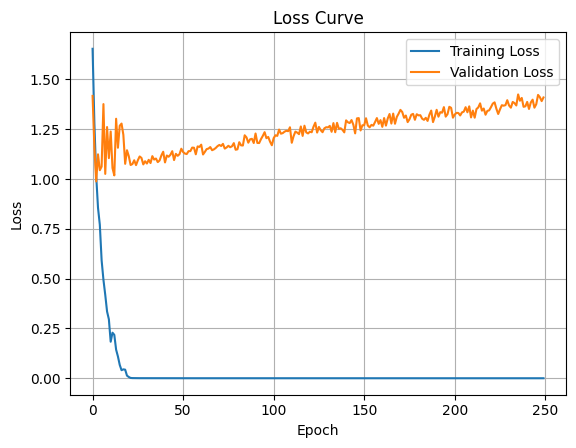

In [14]:
from matplotlib import pyplot as plt
plt.figure(figsize=[6.4, 4.8],facecolor='white', edgecolor='black',dpi=100)

plt.title('Loss Curve')
plt.plot(train_loss,label='Training Loss')
plt.plot(val_loss,label='Validation Loss')
#plt.plot(test_loss,label='Testing Loss')  #comment this for inference
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()

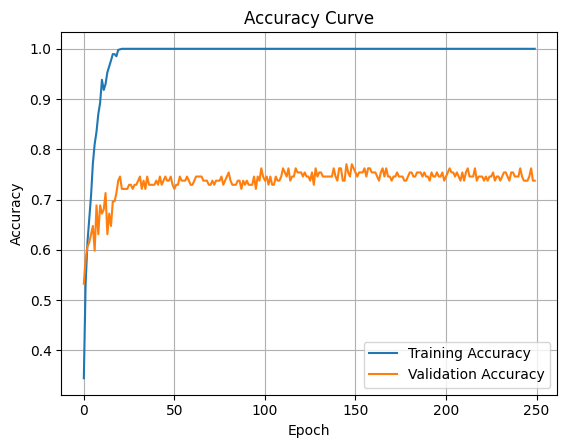

In [15]:
plt.figure(figsize=[6.4, 4.8],facecolor='white', edgecolor='black',dpi=100)
plt.title('Accuracy Curve')
plt.plot(train_acc,label='Training Accuracy')
plt.plot(val_acc,label='Validation Accuracy')
#plt.plot(test_acc,label='Testing Accuracy')  #comment this for inference
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

# Testing The Model

In [16]:
test_loop(test_dataloader, model, criterion)

Validation Loss: 1.4394 Acc: 0.7660


(1.4393601062450003, tensor(0.7660, device='cuda:0', dtype=torch.float64))

In [18]:
torch.save(model, '/content/RavdessResnet50.pth')

In [19]:
summary(model, signal.shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 64, 66, 188]           3,200
       BatchNorm2d-2          [-1, 64, 66, 188]             128
              ReLU-3          [-1, 64, 66, 188]               0
         MaxPool2d-4           [-1, 64, 33, 94]               0
            Conv2d-5           [-1, 64, 33, 94]           4,096
       BatchNorm2d-6           [-1, 64, 33, 94]             128
              ReLU-7           [-1, 64, 33, 94]               0
            Conv2d-8           [-1, 64, 33, 94]          36,864
       BatchNorm2d-9           [-1, 64, 33, 94]             128
             ReLU-10           [-1, 64, 33, 94]               0
           Conv2d-11          [-1, 256, 33, 94]          16,384
      BatchNorm2d-12          [-1, 256, 33, 94]             512
           Conv2d-13          [-1, 256, 33, 94]          16,384
      BatchNorm2d-14          [-1, 256,